In [84]:
import importlib
import Policy 
import Environment
import Diadic

from tqdm.auto import tqdm
tqdm(disable=False)

importlib.reload(Policy)
importlib.reload(Environment)
importlib.reload(Diadic)

import matplotlib.pyplot as plt
import numpy as np

0it [00:00, ?it/s]


In [85]:
class Simulator :
    def __init__(self, algo, env, T) -> None:
        self.algo = algo
        self.env = env
        self.T = T
    
    def run(self):
        for t in tqdm(range(self.T)) :
            x_t = self.algo.choose_action()
            y_t = self.env.get_reward(t, x_t)
            self.algo.update(x_t, y_t)
            self.update_regret(t, x_t)

    def update_regret(self, t, x_t):
        best_mean_value_t = 1 # assuming instances of this kind
        r_t = best_mean_value_t - self.env.get_reward(t, x_t)
        self.algo.regrets.append(r_t)
            

Entering Episode 1
Entering Block 3


/Users/nicolasnguyen/Documents/Projets/Non-Stationary Lipschitz Bandits/NS_Lipschitz_Bandits/Policy.py:270: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


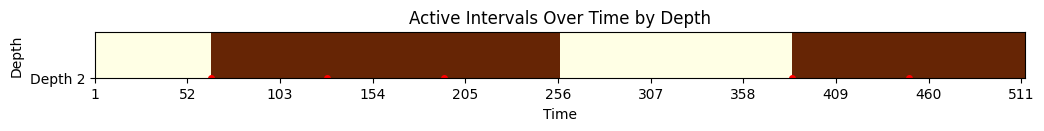

In [86]:
T = 4500
env = Environment.Environment(T, 3)
algo = Policy.MBDE(T)

algo.initialize_episode()
algo.initialize_block()
#algo.tree.activate_depth(2) # TODO: change
algo.tree.update_proba()
#algo.tree.visualize_tree()

algo.tree.visualize()
sim = Simulator(algo, env, T)


 20%|██        | 501/2500 [00:01<00:06, 293.99it/s] 

Entering Block 4


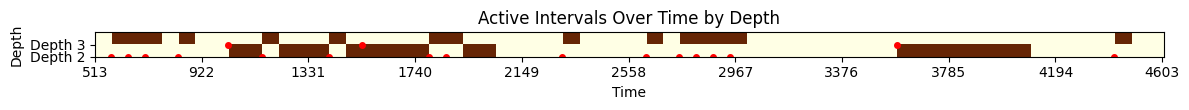

 55%|█████▍    | 1369/2500 [00:19<00:38, 29.29it/s]

evicted with interval [513, 1363]
Node (4, 1) evicted at t=1363 (Replay(2))
evicted with interval [513, 1363]
Node (4, 8) evicted at t=1363 (Replay(2))


 55%|█████▌    | 1384/2500 [00:19<00:27, 41.27it/s]

evicted with interval [513, 1376]
Node (4, 2) evicted at t=1376 (Replay(2))


 70%|██████▉   | 1742/2500 [00:26<00:12, 58.88it/s]

evicted with interval [513, 1733]
Node (4, 7) evicted at t=1733 (Replay(4))


 72%|███████▏  | 1799/2500 [00:27<00:10, 68.69it/s]

evicted with interval [519, 1792]
Node (4, 1) evicted at t=1792 (Replay(2))
evicted with interval [536, 1792]
Node (4, 2) evicted at t=1792 (Replay(2))
evicted with interval [519, 1792]
Node (4, 8) evicted at t=1792 (Replay(2))
evicted with interval [513, 1792]
Node (4, 1) evicted at t=1792 (Replay(2))
evicted with interval [513, 1792]
Node (4, 2) evicted at t=1792 (Replay(2))
evicted with interval [513, 1792]
Node (4, 7) evicted at t=1792 (Replay(2))
evicted with interval [513, 1792]
Node (4, 8) evicted at t=1792 (Replay(2))


 85%|████████▍ | 2120/2500 [00:31<00:06, 57.07it/s]

evicted with interval [513, 2112]
Node (4, 1) evicted at t=2112 (Replay(2))
evicted with interval [513, 2112]
Node (4, 2) evicted at t=2112 (Replay(2))
evicted with interval [544, 2112]
Node (4, 7) evicted at t=2112 (Replay(2))
evicted with interval [513, 2112]
Node (4, 8) evicted at t=2112 (Replay(2))
evicted with interval [513, 2112]
Node (4, 1) evicted at t=2112 (Replay(2))
evicted with interval [513, 2112]
Node (4, 2) evicted at t=2112 (Replay(2))
evicted with interval [513, 2112]
Node (4, 7) evicted at t=2112 (Replay(2))
evicted with interval [513, 2112]
Node (4, 8) evicted at t=2112 (Replay(2))


 90%|████████▉ | 2248/2500 [00:33<00:04, 52.14it/s]

evicted with interval [513, 2240]
Node (4, 1) evicted at t=2240 (Replay(2))
evicted with interval [513, 2240]
Node (4, 2) evicted at t=2240 (Replay(2))
evicted with interval [513, 2240]
Node (4, 8) evicted at t=2240 (Replay(2))
evicted with interval [513, 2240]
Node (4, 1) evicted at t=2240 (Replay(2))
evicted with interval [513, 2240]
Node (4, 2) evicted at t=2240 (Replay(2))
evicted with interval [513, 2240]
Node (4, 7) evicted at t=2240 (Replay(2))
evicted with interval [513, 2240]
Node (4, 8) evicted at t=2240 (Replay(2))


 92%|█████████▏| 2308/2500 [00:35<00:04, 47.74it/s]

evicted with interval [513, 2304]
Node (4, 1) evicted at t=2304 (Replay(2))
evicted with interval [513, 2304]
Node (4, 2) evicted at t=2304 (Replay(2))
evicted with interval [513, 2304]
Node (4, 8) evicted at t=2304 (Replay(2))
evicted with interval [513, 2304]
Node (4, 1) evicted at t=2304 (Replay(2))
evicted with interval [513, 2304]
Node (4, 2) evicted at t=2304 (Replay(2))
evicted with interval [513, 2304]
Node (4, 7) evicted at t=2304 (Replay(2))
evicted with interval [513, 2304]
Node (4, 8) evicted at t=2304 (Replay(2))


 95%|█████████▍| 2374/2500 [00:36<00:02, 48.27it/s]

evicted with interval [513, 2368]
Node (4, 1) evicted at t=2368 (Replay(2))
evicted with interval [513, 2368]
Node (4, 2) evicted at t=2368 (Replay(2))
evicted with interval [513, 2368]
Node (4, 8) evicted at t=2368 (Replay(2))
evicted with interval [513, 2368]
Node (4, 1) evicted at t=2368 (Replay(2))
evicted with interval [513, 2368]
Node (4, 2) evicted at t=2368 (Replay(2))
evicted with interval [513, 2368]
Node (4, 7) evicted at t=2368 (Replay(2))
evicted with interval [513, 2368]
Node (4, 8) evicted at t=2368 (Replay(2))


 98%|█████████▊| 2440/2500 [00:37<00:01, 46.72it/s]

evicted with interval [513, 2432]
Node (4, 1) evicted at t=2432 (Replay(2))
evicted with interval [513, 2432]
Node (4, 2) evicted at t=2432 (Replay(2))
evicted with interval [513, 2432]
Node (4, 8) evicted at t=2432 (Replay(2))
evicted with interval [513, 2432]
Node (4, 1) evicted at t=2432 (Replay(2))
evicted with interval [513, 2432]
Node (4, 2) evicted at t=2432 (Replay(2))
evicted with interval [513, 2432]
Node (4, 7) evicted at t=2432 (Replay(2))
evicted with interval [513, 2432]
Node (4, 8) evicted at t=2432 (Replay(2))


100%|██████████| 2500/2500 [00:38<00:00, 64.33it/s]


In [87]:
sim.run()

In [88]:
sim.algo.StoreActive

defaultdict(dict,
            {4: {'starting': 513, 'ending': 4609},
             2: {'starting': 2432, 'ending': 2496},
             3: {'starting': 1024, 'ending': 1536}})

In [89]:
sim.algo.tree.active_depths

{4: [(4,4), (4,5), (4,6), (4,3)]}

In [90]:
sim.algo.B_MASTER

[(4,4), (4,5), (4,6), (4,3)]

In [91]:
sim.algo.tree.visualize()

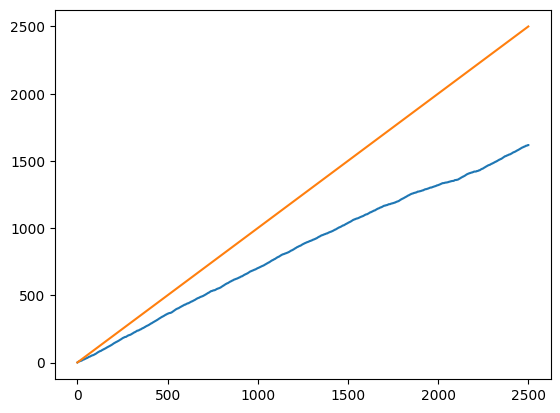

In [92]:
plt.plot(np.cumsum(sim.algo.regrets))
plt.plot(np.cumsum([1 for _ in range(T)]))

In [51]:
def naive_function(x):
    width = 0.3
    center = 0.5
    distance = abs(x - center)
    if distance < width:
        return 1 - distance / width
    else:
        return 0.0

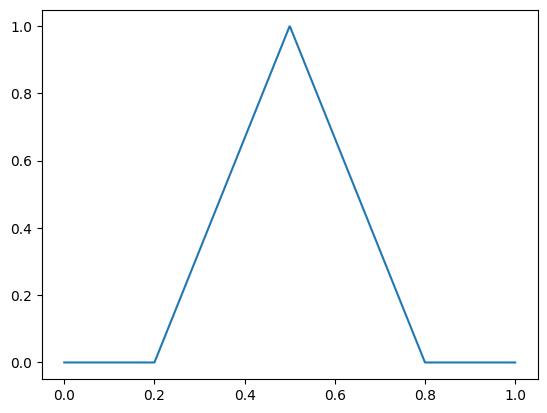

In [52]:
x_list = list(np.linspace(0, 1, 1000))
y_list = [naive_function(x) for x in x_list]

plt.plot(x_list, y_list)

In [65]:
int(np.random.rand() < 0.99)

1